# Causal Effect Estimation with Variational Inference and Latent Confounders

This notebook demonstrates how to estimate the Average Treatment Effect (ATE) using variational
inference in the presence of unobserved confounders. The approach is based on the tutorial  by [Robert Ness](https://scholar.google.com/citations?user=8gWTOBAAAAAJ&hl=en) from his book: [Causal AI book](https://github.com/altdeep/causalAI/blob/master/book/chapter%2011/Chapter_11_Bayesian_Causal_Graphical_Inference.ipynb). We port his Pyro code to NumPyro (this was the objective for me to learn the details of the method).

The fundamental challenge in causal inference from observational data is confounding: variables
that affect both the treatment and outcome can bias naive estimates. When confounders are
unobserved, traditional adjustment methods fail. However, as shown in the CEVAE paper
([Louizos et al., NeurIPS 2017](https://proceedings.neurips.cc/paper_files/paper/2017/file/94b5bde6de888ddf9cde6748ad2523d1-Paper.pdf)),
latent variable models can simultaneously infer the hidden confounders and estimate causal
effects. The variational autoencoder framework provides flexibility to model complex latent
structures without strong parametric assumptions. The encoder (recognition network) learns to
map observed data to the latent confounder distribution, enabling amortized inference.

In this notebook, we estimate the causal effect of side-quest engagement on in-game purchases
in an online game dataset. The causal graph includes an unobserved confounder $Z$ that affects
both treatment and outcome. We compare the Bayesian variational approach with a classical
frontdoor adjustment estimate from DoWhy.

**Warning:** This notebook is not self contained and if you wan to have more details plase look into Chapter 11 in the [Causal AI book](https://www.manning.com/books/causal-ai).

## Prepare Notebook

We use NumPyro for probabilistic modeling, Flax NNX for neural network modules, ArviZ for
diagnostics, and DoWhy for baseline causal identification.

In [1]:
import arviz as az
import graphviz as gr
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
import polars as pl
from dowhy import CausalModel
from flax import nnx
from jax import random
from jaxtyping import Array, Float32, Int32
from numpyro.contrib.module import nnx_module
from numpyro.handlers import condition, do
from numpyro.infer import SVI, Predictive, Trace_ELBO

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Load Data

The dataset contains player behavior from an online game. We focus on four variables:

- **Guild Membership**: Binary indicator of whether a player belongs to a guild.
- **Side-quest Engagement**: Binary indicator of high engagement with side-quests (treatment).
- **Won Items**: Binary indicator of whether the player won items through gameplay.
- **In-game Purchases**: Continuous variable measuring purchase amount (outcome).

We are interested in the causal effect of side-quest engagement on in-game purchases.

The original dataset contains more confounders, but we encode these as unobserved confounder $Z$ as we typically won't have access to them in many real world cases.

In [2]:
data_path = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/online_game_ate.csv"

raw_df = pl.read_csv(data_path)


columns_to_keep = [
    "Guild Membership",
    "Side-quest Engagement",
    "Won Items",
    "In-game Purchases",
]

df = raw_df[columns_to_keep]

df.head()

Guild Membership,Side-quest Engagement,Won Items,In-game Purchases
i64,i64,i64,f64
0,1,1,1030.29
0,1,0,2453.34
0,1,1,3761.4
1,1,1,1007.84
0,1,0,4153.94


## Specify Causal Graph

The causal graph encodes our assumptions about the data generating process:

- **Treatment**: Side-quest Engagement
- **Outcome**: In-game Purchases
- **Mediator**: Won Items (lies on the causal path from treatment to outcome)
- **Observed common cause**: Guild Membership (affects both engagement and purchases)
- **Unobserved confounder**: $Z$ (affects both engagement and purchases)

Because $Z$ is unobserved, we cannot use backdoor adjustment directly. However, the causal
effect is still identifiable via the **frontdoor criterion**: Won Items fully mediates the
effect of Side-quest Engagement on In-game Purchases (condition 1), there is no unblocked
backdoor path from treatment to mediator (condition 2), and all backdoor paths from mediator
to outcome are blocked by the treatment (condition 3).

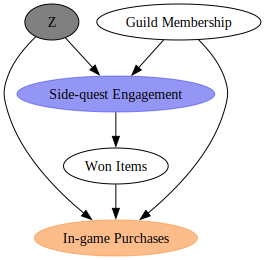

In [3]:
g = gr.Digraph()

g.node("Side-quest Engagement", color="#2a2eec80", style="filled")
g.node("In-game Purchases", color="#fa7c1780", style="filled")

g.node("Z", style="filled", fillcolor="gray")

g.edge("Side-quest Engagement", "Won Items")
g.edge("Won Items", "In-game Purchases")
g.edge("Guild Membership", "Side-quest Engagement")
g.edge("Guild Membership", "In-game Purchases")

g.edge("Z", "Side-quest Engagement")
g.edge("Z", "In-game Purchases")

g

In [4]:
# Convert graphviz graph to networkx
# (a bit hacky, there should be a better way to do this)
# It works tho ¯\_(ツ)_/¯
g_nx = nx.DiGraph()

# Extract edges from graphviz graph
for edge in g.body:
    if "->" in edge:
        # Parse edge string (format: "node1 -> node2")
        parts = edge.strip().split("->")
        source = parts[0].strip().strip('"')
        target = parts[1].strip().strip('"')
        g_nx.add_edge(source, target)

## Define DoWhy Causal Model

We use DoWhy to formalize the causal model and identify estimands. This serves as a baseline
for comparison with our Bayesian approach.

/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/dowhy/causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


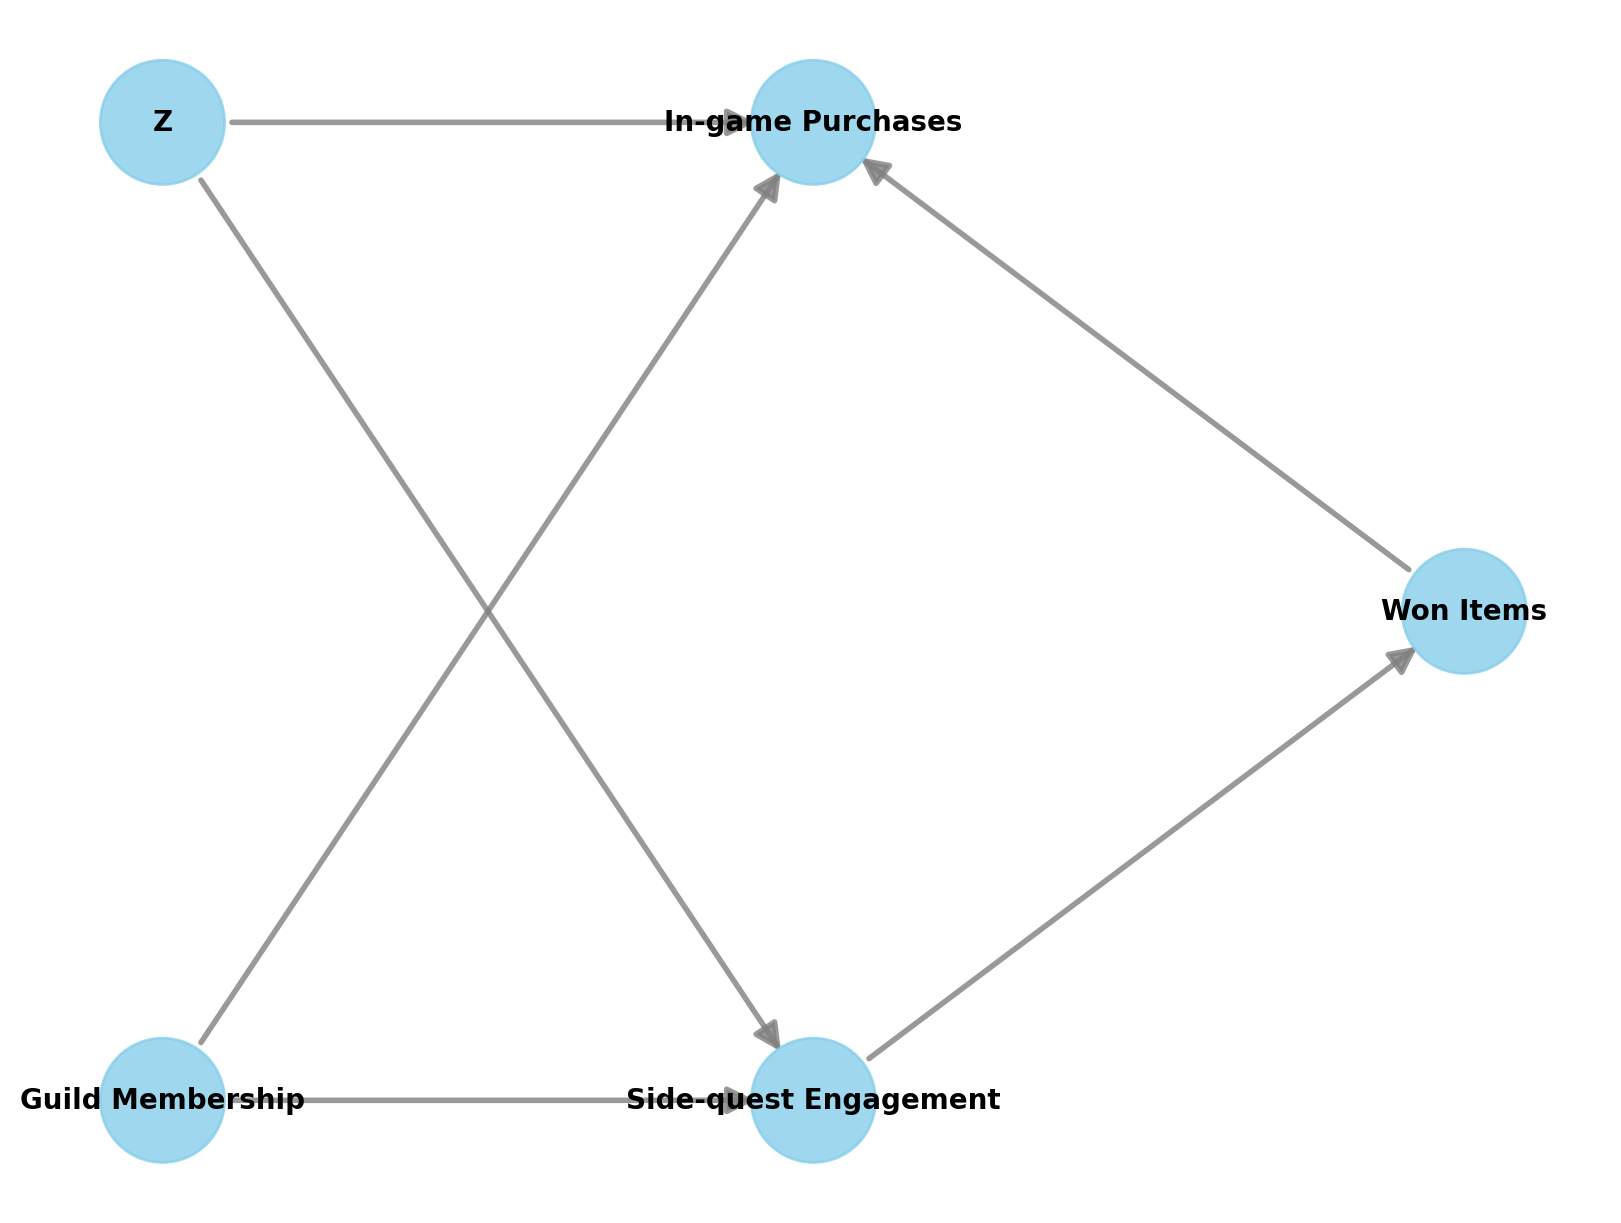

In [5]:
model = CausalModel(
    data=df.to_pandas(),
    graph=g_nx,
    treatment="Side-quest Engagement",
    outcome="In-game Purchases",
)

model.view_model()

## Estimate ATE with DoWhy

DoWhy identifies the frontdoor estimand and we choose to estimate the ATE using two-stage regression
(you can choose other methods, see Causal AI book, Chapter 11).
This provides a point estimate with confidence intervals that we will later compare to the
posterior distribution from our Bayesian model.

In [6]:
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡     d                                     d                         ⎤
E⎢────────────(In-game Purchases)⋅────────────────────────([Won Items])⎥
 ⎣d[Won Items]                    d[Side-quest Engagement]             ⎦
Estimand assumption 1, Full-mediation: Won Items intercepts (blocks) all directed paths from Side-quest Engagement to I,n,-,g,a,m,e, ,P,u,r,c,h,a,s,e,s.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Side-quest Engagement} and U→{Won Items} then P(Won Items|Side-quest Engagement,U) = P(Won Items|Side-quest Engagement)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Won Items} and U→In-game Purchases then P(In-game Purchases|Won Items, Side-quest Engagement, U) = P(In-game Purchases|Won Items, Side-quest Engage

In [7]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="frontdoor.two_stage_regression",
    target_units="ate",
    method_params={"weighting_scheme": "ips_weight"},
    test_significance=True,
    confidence_intervals=True,
)

estimate_value = estimate.value
estimate_ci = estimate.get_confidence_intervals()

print(f"Estimate of causal effect (linear regression): {estimate_value}")
print(f"confidence interval: {estimate_ci}")

Estimate of causal effect (linear regression): 170.2056058128939
confidence interval: (np.float64(131.47626085168193), np.float64(211.94154274497268))


## Prepare Data for Bayesian Model

Now we want to estimate the ATE effect using a Bayesian model explicitly.

First, we convert the data to JAX arrays for use in the NumPyro model.

In [8]:
is_guild_member: Int32[Array, " n_obs"] = df["Guild Membership"].to_jax()
is_highly_engaged: Int32[Array, " n_obs"] = df["Side-quest Engagement"].to_jax()
won_items: Int32[Array, " n_obs"] = df["Won Items"].to_jax()
in_game_purchases: Float32[Array, " n_obs"] = df["In-game Purchases"].to_jax()

## Specify Bayesian Model

We now build a Bayesian model that explicitly represents the unobserved confounder $Z$ as a
latent variable. The model uses neural networks to parameterize flexible conditional
distributions, following the structure of the causal graph. Variational inference allows us
to scale to large datasets while inferring the posterior over both model parameters and the
latent confounder.

### Neural Network Modules

We define two neural networks using Flax NNX:

- `Confounders2Engagement`: Maps guild membership and latent confounder $Z$ to the probability
  of high engagement. This captures how the observed covariate and latent confounder jointly
  influence the treatment.
- `PurchasesNetwork`: Maps won items, guild membership, and $Z$ to the purchase distribution
  (mean and standard deviation). This captures how the mediator, observed covariate, and
  latent confounder influence the outcome.

In [9]:
class Confounders2Engagement(nnx.Module):
    def __init__(
        self,
        input_dim: int = 2,
        output_dim: int = 1,
        hidden_dim: int = 5,
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.fc1 = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_engagement_ρ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        hidden = jax.nn.softplus(self.fc1(x))
        ρ_engagement = jax.nn.sigmoid(self.f_engagement_ρ(hidden))
        return ρ_engagement.T.squeeze(0)


class PurchasesNetwork(nnx.Module):
    def __init__(
        self,
        input_dim=3,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_purchase_μ = nnx.Linear(hidden_dim, 1, rngs=rngs)
        self.f_purchase_σ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        hidden = jax.nn.softplus(self.f_hidden(x))
        μ_purchases = self.f_purchase_μ(hidden)
        σ_purchases = eps + jax.nn.softplus(self.f_purchase_σ(hidden))
        μ_purchases = μ_purchases.T.squeeze(0)
        σ_purchases = σ_purchases.T.squeeze(0)
        return μ_purchases, σ_purchases

We do an eager initialization of the neural networks.

In [10]:
rng_key, rng_subkey = random.split(rng_key)
nn_confounders_2_engagement = Confounders2Engagement(rngs=nnx.Rngs(rng_subkey))

rng_key, rng_subkey = random.split(rng_key)
nn_purchases_network = PurchasesNetwork(rngs=nnx.Rngs(rng_subkey))

### NumPyro Model

The generative model follows the causal graph structure:

1. Sample the latent confounder $Z \sim \text{Normal}(0, 1)$ for each observation.
2. Sample guild membership from a Bernoulli with probability $\rho_{\text{member}}$.
3. Compute engagement probability using the neural network on (guild membership, $Z$).
4. Sample side-quest engagement from a Bernoulli.
5. Sample won items, where the probability depends on engagement status.
6. Compute purchase distribution using the neural network on (won items, guild membership, $Z$).
7. Sample in-game purchases from a Normal distribution.

The [`nnx_module`](https://num.pyro.ai/en/stable/primitives.html#nnx-module) function integrates Flax NNX modules into NumPyro, treating network weights
as parameters to be learned during inference. For more details, see the blog post [PyData Berlin 2025: Introduction to Stochastic Variational Inference with NumPyro](https://juanitorduz.github.io/intro_svi/).

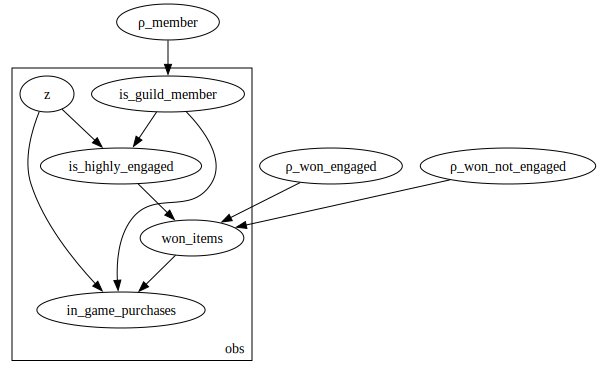

In [11]:
eps = jnp.finfo(jnp.float32).eps


def is_highly_engaged_model(z: jax.Array, is_guild_member: jax.Array) -> jax.Array:
    """
    This function models the probability of high engagement as a function of guild
    membership and the latent confounder $Z$. We use a neural network to model the
    relationship.
    """
    engagement_input = jnp.stack((is_guild_member, z)).T

    nnx_confounders_2_engagement = nnx_module(
        "nnx_confounders_2_engagement", nn_confounders_2_engagement
    )

    ρ_engagement = nnx_confounders_2_engagement(engagement_input)

    return numpyro.sample(
        "is_highly_engaged",
        dist.Bernoulli(ρ_engagement),
    )


def won_items_model(
    ρ_won_engaged: jax.Array,
    ρ_won_not_engaged: jax.Array,
    is_highly_engaged: jax.Array,
) -> jax.Array:
    """
    This function models the probability of won items as a function of
    engagement status.
    """
    p_won = ρ_won_engaged * is_highly_engaged + ρ_won_not_engaged * (
        1 - is_highly_engaged
    )

    return numpyro.sample("won_items", dist.Bernoulli(p_won))


def purchases_model(
    z: jax.Array, is_guild_member: jax.Array, won_items: jax.Array
) -> None:
    """
    This function models the purchase distribution as a function of won items,
    guild membership, and the latent confounder $Z$. We use a neural network to
    model the relationship.
    """
    purchase_input = jnp.stack((won_items, is_guild_member, z)).T

    nnx_purchases_network = nnx_module("nnx_purchases_network", nn_purchases_network)

    μ_purchases, σ_purchases = nnx_purchases_network(purchase_input)

    numpyro.sample("in_game_purchases", dist.Normal(μ_purchases, σ_purchases))


# Some function arguments are not used.
# The reason is need to have the same signature as the guide function (below).
def model(
    is_guild_member: Int32[Array, " n_obs"],
    is_highly_engaged: Int32[Array, " n_obs"],
    won_items: Int32[Array, " n_obs"],
    in_game_purchases: Float32[Array, " n_obs"],
) -> None:
    n_obs = is_guild_member.shape[0]

    ρ_member = numpyro.sample("ρ_member", dist.Beta(2, 5))

    ρ_won_engaged = numpyro.sample("ρ_won_engaged", dist.Beta(5, 2))
    ρ_won_not_engaged = numpyro.sample("ρ_won_not_engaged", dist.Beta(2, 5))

    with numpyro.plate("obs", n_obs):
        z = numpyro.sample("z", dist.Normal(0.0, 1.0))

        is_guild_member = numpyro.sample("is_guild_member", dist.Bernoulli(ρ_member))

        is_highly_engaged = is_highly_engaged_model(z, is_guild_member)

        won_items = won_items_model(ρ_won_engaged, ρ_won_not_engaged, is_highly_engaged)

        purchases_model(z, is_guild_member, won_items)


numpyro.render_model(
    model,
    model_kwargs={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

Here we see how the model captures the causal graph structure (by design).

### Condition Model on Data

We use NumPyro's [`condition`](https://num.pyro.ai/en/stable/handlers.html#condition) handler to fix the observed variables to their data values.
This transforms the generative model into a model suitable for inference, where only the
latent confounder $Z$ and model parameters remain to be inferred.

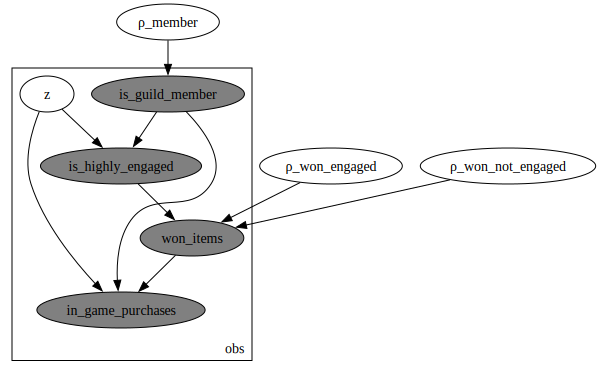

In [12]:
conditioned_model = condition(
    model,
    data={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

numpyro.render_model(
    conditioned_model,
    model_kwargs={
        "is_guild_member": is_guild_member,
        "is_highly_engaged": is_highly_engaged,
        "won_items": won_items,
        "in_game_purchases": in_game_purchases,
    },
)

## Implement Custom Guide

The guide (variational distribution) specifies the approximate posterior family for inference.
It has two components:

- **Global parameters**: Beta distributions for $\rho_{\text{member}}$, $\rho_{\text{won\_engaged}}$,
  and $\rho_{\text{won\_not\_engaged}}$, with learnable concentration parameters.
- **Local latent variable**: The `Encoder` network implements amortized inference for $Z$.
  Given observed data (guild membership, engagement, purchases), it outputs the mean and
  standard deviation of a Normal distribution over $Z$. This is the recognition network
  that maps observations to the latent confounder posterior.

In [13]:
class Encoder(nnx.Module):
    def __init__(
        self,
        input_dim=3,
        z_dim=1,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_loc = nnx.Linear(hidden_dim, z_dim, rngs=rngs)
        self.f_scale = nnx.Linear(hidden_dim, z_dim, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        x = x.T
        hidden = jax.nn.softplus(self.f_hidden(x))
        z_loc = self.f_loc(hidden)
        z_scale = eps + jax.nn.softplus(self.f_scale(hidden))
        return z_loc.T.squeeze(0), z_scale.T.squeeze(0)


rng_key, rng_subkey = random.split(rng_key)
nn_encoder = Encoder(rngs=nnx.Rngs(rng_subkey))

We are now ready to define the guide.

In [14]:
def ρ_member_guide() -> None:
    α_member = numpyro.param("α_member", jnp.array(1.0))
    β_member = numpyro.param("β_member", jnp.array(1.0))
    numpyro.sample("ρ_member", dist.Beta(α_member, β_member))


def ρ_won_engaged_guide() -> None:
    α_won_engaged = numpyro.param(
        "α_won_engaged", jnp.array(5.0), constraint=dist.constraints.positive
    )
    β_won_engaged = numpyro.param(
        "β_won_engaged", jnp.array(2.0), constraint=dist.constraints.positive
    )
    numpyro.sample("ρ_won_engaged", dist.Beta(α_won_engaged, β_won_engaged))


def ρ_won_not_engaged_guide() -> None:
    α_won_not_engaged = numpyro.param(
        "α_won_not_engaged", jnp.array(2.0), constraint=dist.constraints.positive
    )
    β_won_not_engaged = numpyro.param(
        "β_won_not_engaged", jnp.array(5.0), constraint=dist.constraints.positive
    )
    beta_dist = dist.Beta(α_won_not_engaged, β_won_not_engaged)
    numpyro.sample("ρ_won_not_engaged", beta_dist)


def guide(
    is_guild_member: Int32[Array, " n_obs"],
    is_highly_engaged: Int32[Array, " n_obs"],
    won_items: Int32[Array, " n_obs"],
    in_game_purchases: Float32[Array, " n_obs"],
) -> None:
    ρ_member_guide()
    ρ_won_engaged_guide()
    ρ_won_not_engaged_guide()

    n_obs = is_guild_member.shape[0]

    nnx_encoder = nnx_module("nnx_encoder", nn_encoder)

    with numpyro.plate("obs", n_obs):
        z_input = jnp.stack((is_guild_member, is_highly_engaged, in_game_purchases))
        z_loc, z_scale = nnx_encoder(z_input)
        numpyro.sample("z", dist.Normal(z_loc, z_scale))

## Model Fit

We train the model using Stochastic Variational Inference (SVI) with the Evidence Lower Bound
(ELBO) as the objective. The optimizer combines Adam with a one-cycle learning rate schedule
and plateau-based reduction for stable convergence.

100%|██████████| 120000/120000 [02:46<00:00, 721.64it/s, init loss: 14015630336.0000, avg. loss [114001-120000]: 120616.9844]


CPU times: user 4min 5s, sys: 48.8 s, total: 4min 53s
Wall time: 2min 51s


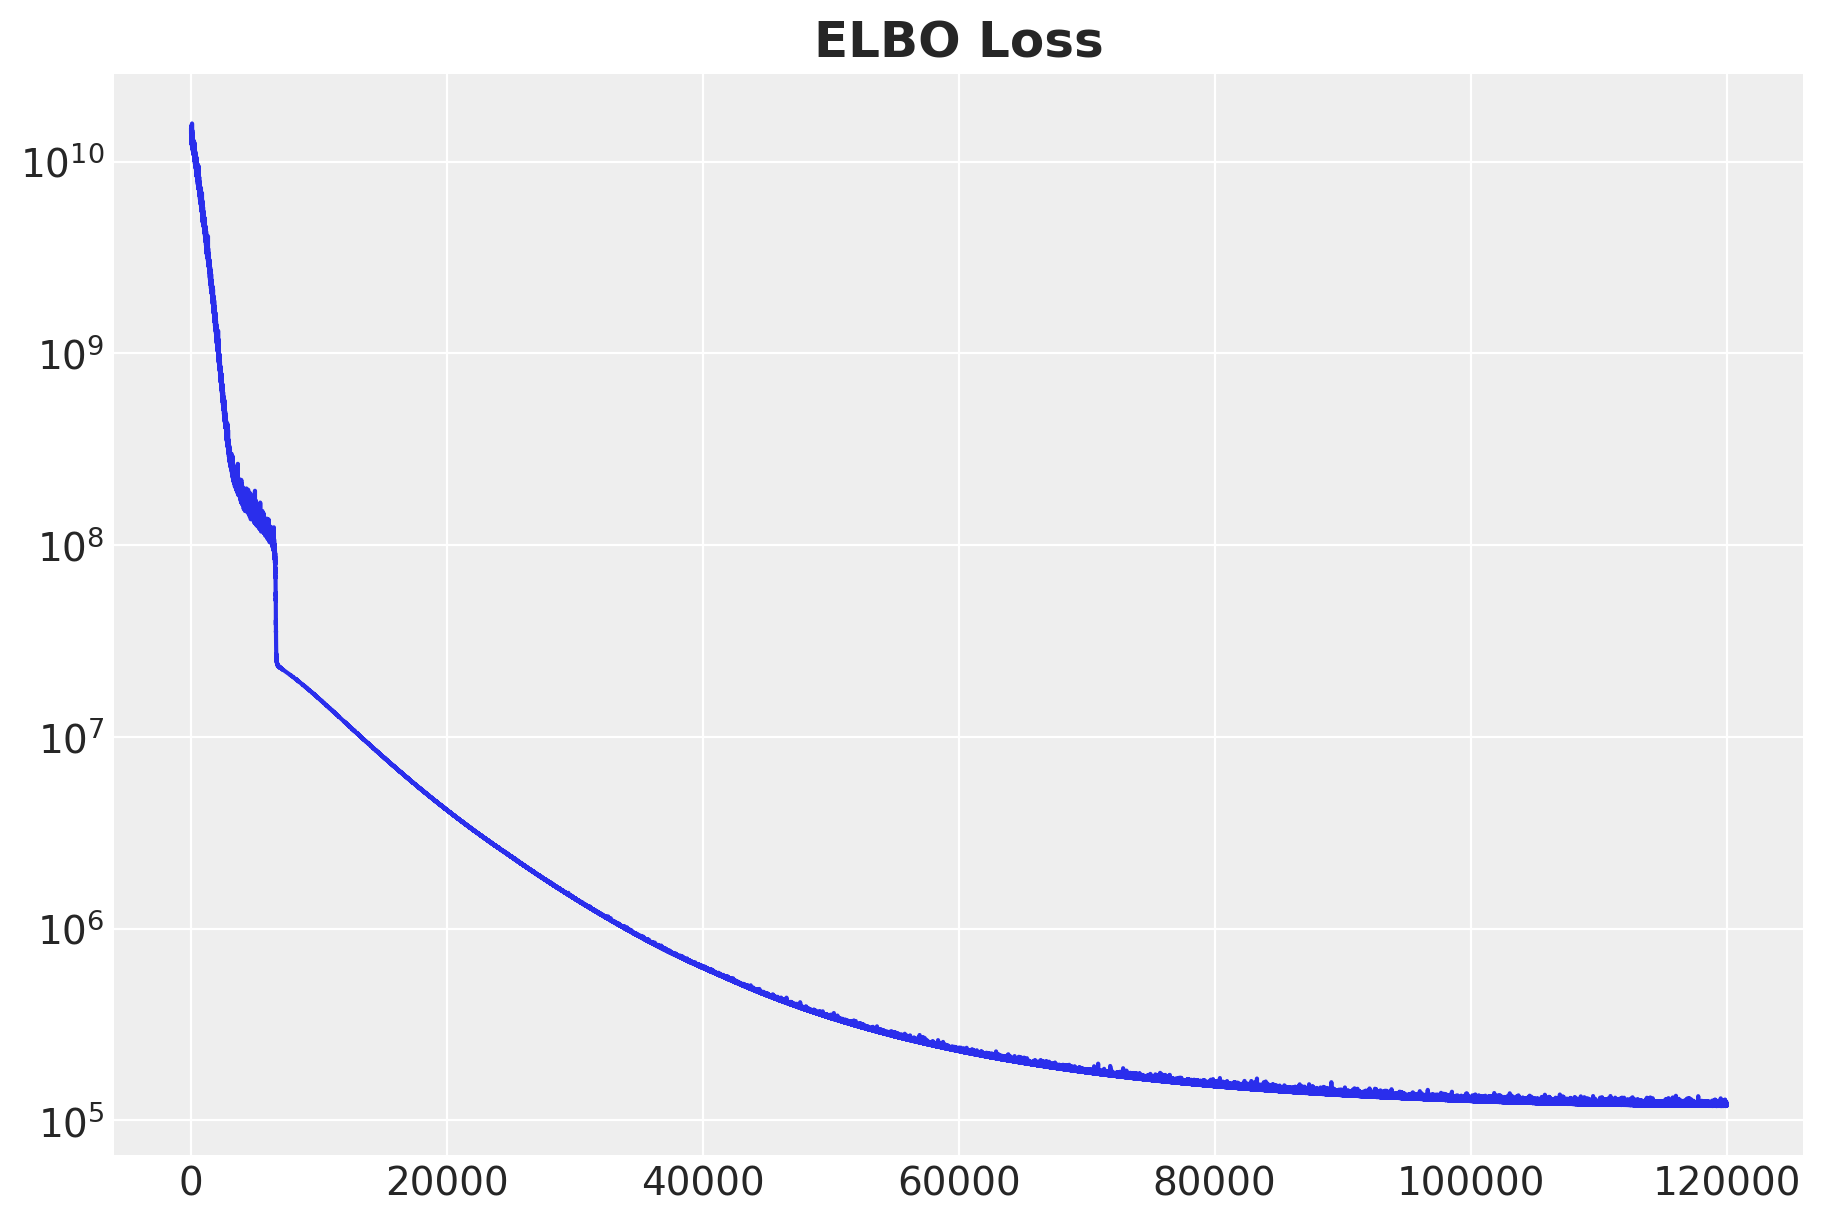

In [15]:
%%time

n_samples = 120_000
scheduler = optax.linear_onecycle_schedule(
    transition_steps=n_samples,
    peak_value=0.0001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.8,
        patience=20,
        accumulation_size=100,
    ),
)

svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    n_samples,
    is_guild_member=is_guild_member,
    is_highly_engaged=is_highly_engaged,
    won_items=won_items,
    in_game_purchases=in_game_purchases,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

Overall, the ELBO loss is decreasing monotonically, as expected.

## Posterior Predictive Sampling

We validate the model by generating posterior predictive samples and comparing them to
observed data. A well-calibrated model should produce predictions that resemble the
empirical distribution of in-game purchases.

In [16]:
params = svi_result.params

posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=[
        "in_game_purchases",
    ],
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey,
    is_guild_member,
    is_highly_engaged,
    won_items,
    in_game_purchases,
)

idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    observed_data={
        "in_game_purchases": in_game_purchases,
    },
    coords={"obs_idx": range(df.shape[0])},
    dims={
        "in_game_purchases": ["obs_idx"],
    },
)

Text(0.5, 1.0, 'Posterior Predictive Check')

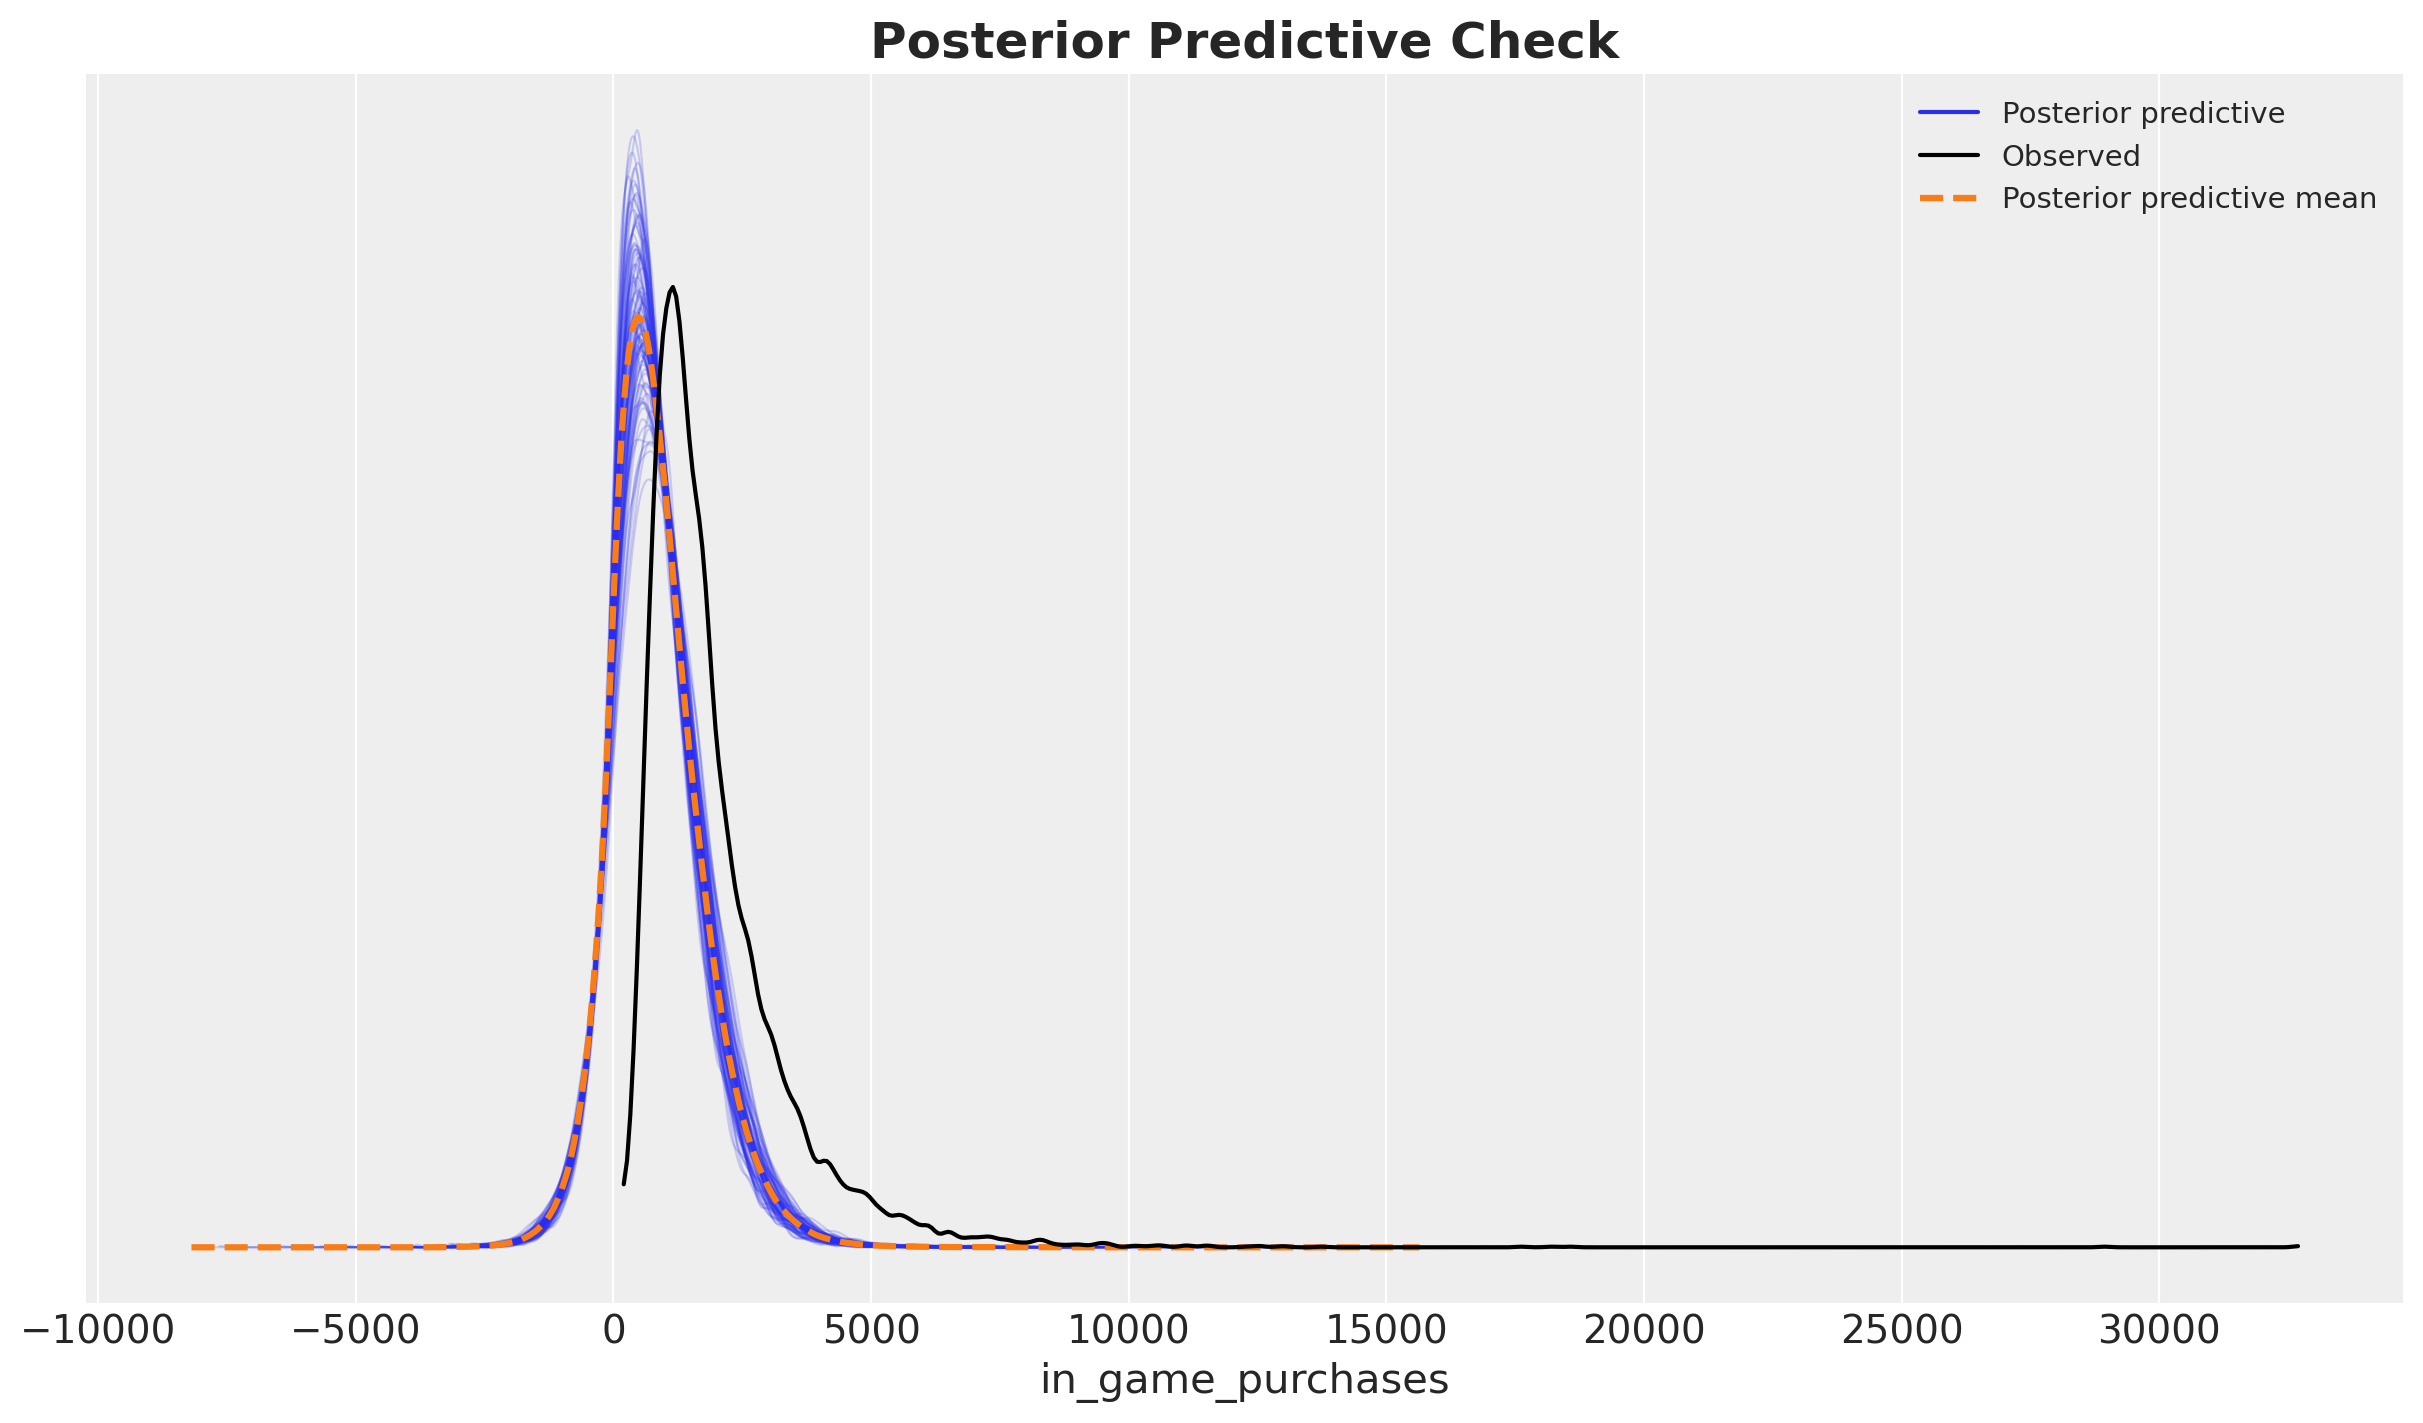

In [17]:
fig, ax = plt.subplots()
rng_key, rng_subkey = random.split(rng_key)
az.plot_ppc(idata, num_pp_samples=100, group="posterior", random_seed=rng_subkey, ax=ax)
ax.set_title("Posterior Predictive Check", fontsize=18, fontweight="bold")

Ok, the model is not terrible, but also nos great. It seems the posterior predictive has the expected shape but it is skewed.

## Apply Do Operator and Estimate ATE

To estimate causal effects, we use NumPyro's [`do`](https://num.pyro.ai/en/stable/handlers.html#do) handler to implement interventions. The [`do`](https://num.pyro.ai/en/stable/handlers.html#do)
operator sets a variable to a fixed value, breaking incoming causal arrows. We compute the ATE
as:

$$\text{ATE} = \mathbb{E}[Y \mid \text{do}(T=1)] - \mathbb{E}[Y \mid \text{do}(T=0)]$$

where $T$ is side-quest engagement and $Y$ is in-game purchases.

### Critical: Using the Same $Z$ for Both Interventions

A naive approach would be to run separate `Predictive` calls with `do(T=0)` and `do(T=1)`.
However, this would sample **different** $Z$ values for each intervention, leading to
inflated variance in the ATE estimate (we'd be comparing different individuals!).

The correct approach is:
1. **Sample $Z$ once** from the guide
2. **Condition on the same $Z$** when computing outcomes under both interventions
3. This ensures we compare potential outcomes for the **same** individuals

We use the combination of `condition` (to fix $Z$) and `do` (to intervene on treatment).

In [ ]:
num_samples = 5_000
n_obs = is_guild_member.shape[0]

# Step 1: Sample z from the guide (infers z from observed data)
z_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=num_samples,
    return_sites=["z"],
)

rng_key, rng_subkey = random.split(rng_key)
z_samples = z_predictive(
    rng_subkey,
    is_guild_member,
    is_highly_engaged,
    won_items,
    in_game_purchases,
)["z"]  # Shape: (num_samples, n_obs)


# Step 2: Compute outcomes under both interventions using the SAME z samples
def compute_purchases_under_intervention(rng_key, z_sample, treatment_value, params):
    """Compute in_game_purchases under do(is_highly_engaged=treatment_value)
    with fixed z.

    This ensures we use the same z for both interventions, giving us valid
    counterfactual comparisons for the same individuals.
    """
    # Intervene on treatment AND condition on z
    intervened_model = do(
        condition(model, data={"z": z_sample}),
        data={"is_highly_engaged": jnp.full(n_obs, treatment_value)},
    )

    predictive = Predictive(
        model=intervened_model,
        params=params,
        num_samples=1,
        return_sites=["in_game_purchases"],
    )

    return predictive(
        rng_key, is_guild_member, is_highly_engaged, won_items, in_game_purchases
    )["in_game_purchases"].squeeze(0)


# Compute purchases under both interventions for each z sample
rng_key, rng_subkey = random.split(rng_key)
rng_keys = random.split(rng_subkey, num_samples * 2)

# Y(0): Purchases under do(is_highly_engaged=0)
purchases_t0_samples = jax.vmap(
    lambda z, key: compute_purchases_under_intervention(key, z, 0, params)
)(z_samples, rng_keys[:num_samples])

# Y(1): Purchases under do(is_highly_engaged=1)
purchases_t1_samples = jax.vmap(
    lambda z, key: compute_purchases_under_intervention(key, z, 1, params)
)(z_samples, rng_keys[num_samples:])

# Create InferenceData objects for visualization (same structure as before)
do_0_idata = az.from_dict(
    posterior_predictive={
        "in_game_purchases": np.expand_dims(np.asarray(purchases_t0_samples), axis=0)
    },
    observed_data={"in_game_purchases": in_game_purchases},
    coords={"obs_idx": range(n_obs)},
    dims={"in_game_purchases": ["obs_idx"]},
)

do_1_idata = az.from_dict(
    posterior_predictive={
        "in_game_purchases": np.expand_dims(np.asarray(purchases_t1_samples), axis=0)
    },
    observed_data={"in_game_purchases": in_game_purchases},
    coords={"obs_idx": range(n_obs)},
    dims={"in_game_purchases": ["obs_idx"]},
)

Before computing the ATE, we can visualize the posterior predictive for both interventions.

Text(0.5, 1.0, 'Posterior Predictive Check\ndo(is_highly_engaged=1) vs do(is_highly_engaged=0)')

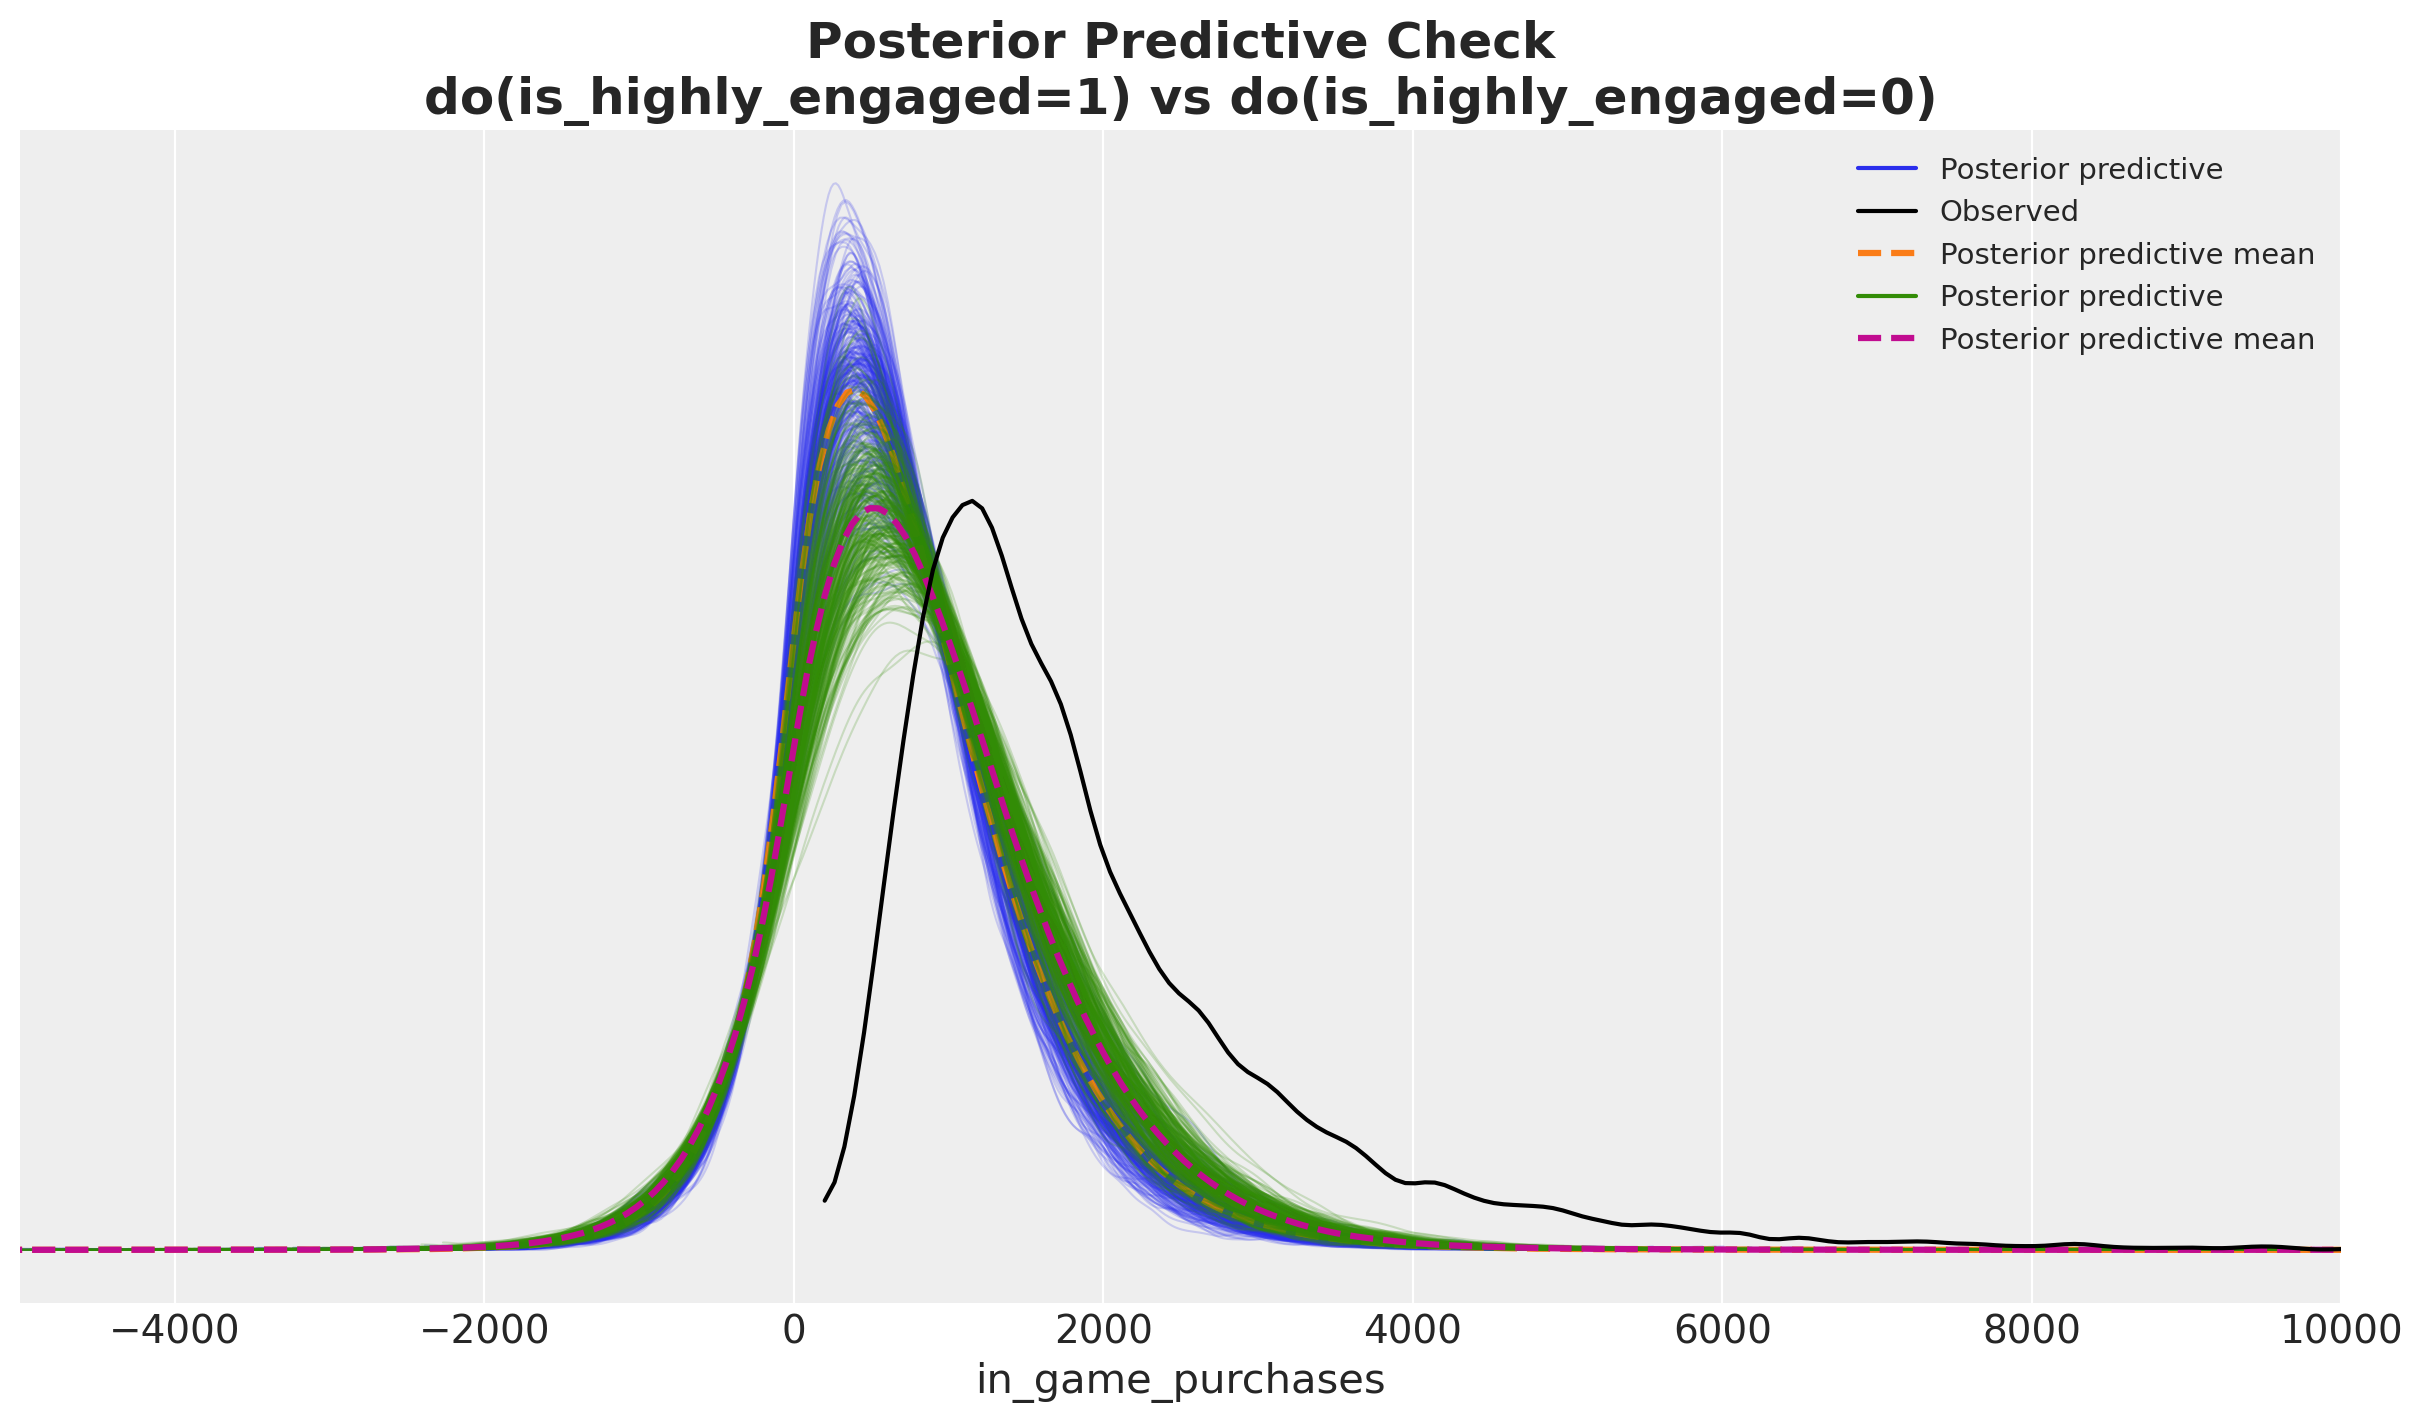

In [19]:
num_pp_samples = 300

fig, ax = plt.subplots()
az.plot_ppc(
    do_0_idata,
    num_pp_samples=num_pp_samples,
    group="posterior",
    ax=ax,
)
az.plot_ppc(
    do_1_idata,
    num_pp_samples=num_pp_samples,
    group="posterior",
    observed=False,
    colors=["C2", "k", "C3"],
    ax=ax,
)
ax.set(xlim=(-5_000, 10_000))
ax.set_title(
    "Posterior Predictive Check\ndo(is_highly_engaged=1) vs do(is_highly_engaged=0)",
    fontsize=18,
    fontweight="bold",
)

Now we can compute the ATE by taking the mean of the difference between the posterior predictive for the two interventions.

Text(0.5, 1.0, 'ATE Posterior Distribution')

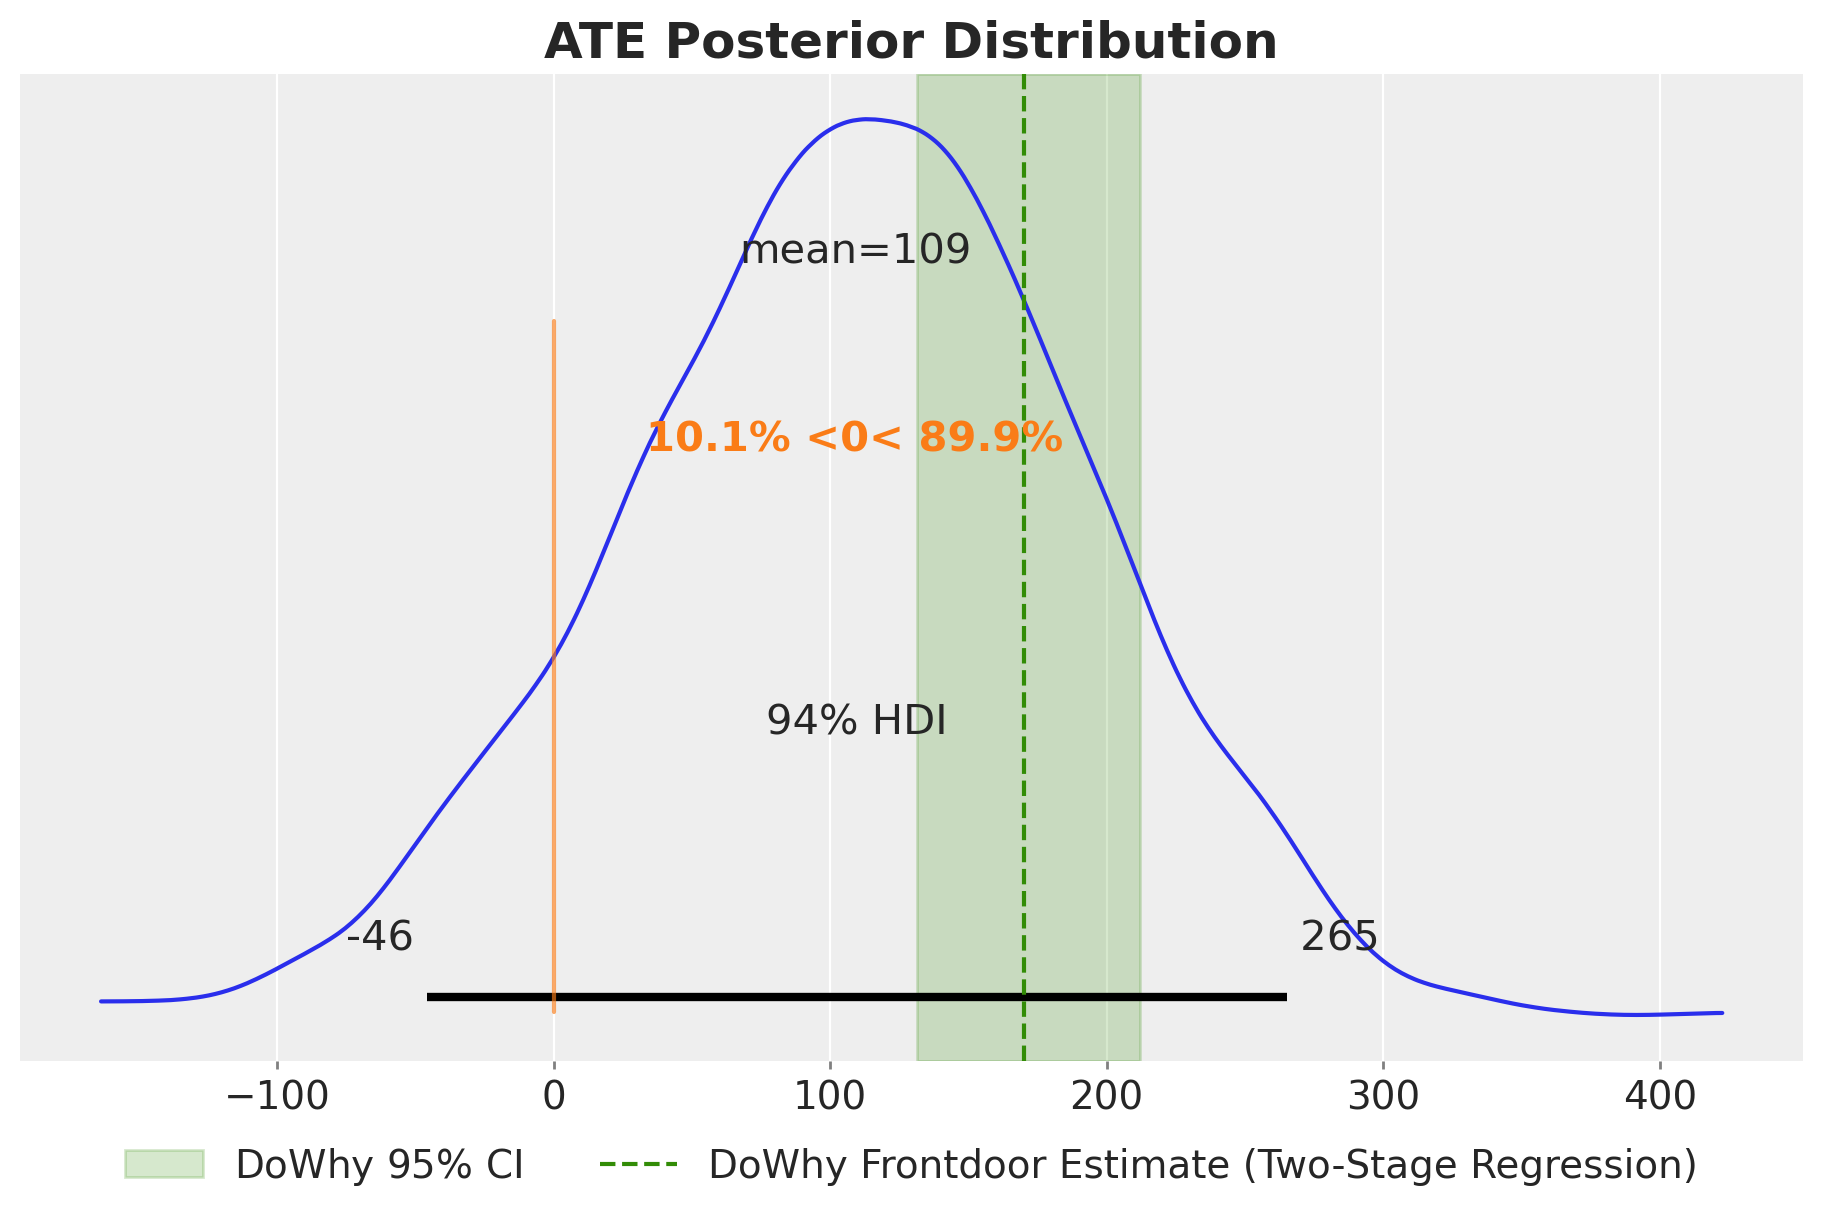

In [20]:
ate = (
    (
        do_1_idata["posterior_predictive"]["in_game_purchases"]
        - do_0_idata["posterior_predictive"]["in_game_purchases"]
    )
    .mean(dim="obs_idx")
    .rename("ate")
)


fig, ax = plt.subplots(figsize=(9, 6))
az.plot_posterior(ate, ref_val=0, ax=ax)
ax.axvspan(
    estimate_ci[0], estimate_ci[1], color="C2", alpha=0.2, label=r"DoWhy $95\%$ CI"
)
ax.axvline(
    estimate_value,
    color="C2",
    linestyle="--",
    label="DoWhy Frontdoor Estimate (Two-Stage Regression)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
ax.set_title("ATE Posterior Distribution", fontsize=18, fontweight="bold")

The posterior distribution over the ATE aligns well with the DoWhy frontdoor estimate.
By using the same $Z$ samples for both interventions, we obtain a tighter credible interval
that properly reflects uncertainty about the causal effect.

## Summary and Conclusion

This notebook demonstrated how to estimate causal effects in the presence of unobserved
confounders using variational inference. We built a Bayesian model in NumPyro that explicitly
represents the latent confounder $Z$ and uses neural networks to parameterize flexible
conditional distributions. The encoder network enables amortized inference, learning to map
observed data to the posterior distribution over the hidden confounder.

### Key Implementation Detail: Consistent $Z$ Samples

A critical insight is that when computing the ATE as $\mathbb{E}[Y(1) - Y(0)]$, we must
use the **same** $Z$ samples for both potential outcomes. The naive approach of running
separate `do()` interventions samples different $Z$ values, which:

- Compares outcomes for **different individuals** rather than counterfactuals
- Inflates variance in the ATE estimate
- Does not properly answer the causal question

The correct approach uses `condition(model, {"z": z_sample})` combined with `do()` to
ensure both potential outcomes are computed for the same latent confounder values.

The posterior distribution over the ATE aligns well with the DoWhy frontdoor estimate,
providing validation for both approaches. The Bayesian method offers the additional benefit
of uncertainty quantification through the full posterior, rather than relying solely on
asymptotic confidence intervals. This framework can be extended to more complex causal
structures and larger datasets, leveraging the scalability of stochastic variational inference.